In [1]:
import numpy as np 
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import model_from_json

# import pydot
# import graphviz
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import pickle

from IPython.display import SVG
from keras.utils import np_utils 
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# from keras.utils.training_utils import multi_gpu_model

import matplotlib.pyplot as plt

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers


import tensorflow as tf
import os

/home/suhaila/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Loading data and normalizing the input images and mask outputs so that 
#all the values fall between 0 and 1

X_train  = np.load('dataset/X_train.npy')
X_train = X_train/255
Y_train  = np.load('dataset/Y_train.npy')
Y_train = Y_train/255
D_train  = np.load('dataset/D_train.npy')

X_val  = np.load('dataset/X_val.npy')
X_val = X_val/255
Y_val  = np.load('dataset/Y_val.npy')
Y_val = Y_val/255
D_val  = np.load('dataset/D_val.npy')

X_test  = np.load('dataset/X_test.npy')
X_test = X_test/255
Y_test  = np.load('dataset/Y_test.npy')
Y_test = Y_test/255
D_test  = np.load('dataset/D_test.npy')

#Print shapes
print('Shape of training set input: ',X_train.shape)
print('Shape of training masks: ',Y_train.shape)
print('Shape of training bounding box and scores: ', D_train.shape)
print('\n')
print('Shape of validation set input: ',X_val.shape)
print('Shape of validation masks: ',Y_val.shape)
print('Shape of valiation bounding box and scores: ', D_val.shape)
print('\n')
print('Shape of testing set input: ',X_test.shape)
print('Shape of testing masks: ',Y_test.shape)
print('Shape of testing bounding box and scores: ', D_test.shape)

Shape of training set input:  (536, 256, 256, 3)
Shape of training masks:  (536, 256, 256, 1)
Shape of training bounding box and scores:  (536, 32, 32, 5)


Shape of validation set input:  (67, 256, 256, 3)
Shape of validation masks:  (67, 256, 256, 1)
Shape of valiation bounding box and scores:  (67, 32, 32, 5)


Shape of testing set input:  (67, 256, 256, 3)
Shape of testing masks:  (67, 256, 256, 1)
Shape of testing bounding box and scores:  (67, 32, 32, 5)


In [7]:
#Defining loss functions 

#Loss for bounding box regression and class probabilities 

def bbox_score_loss(y_true,y_pred):
    
    prob_true_flat = K.flatten(y_true[:,:,:,0])
    prob_pred_flat = K.flatten(y_pred[:,:,:,0])
    
    prob_pred_flat = K.clip(prob_pred_flat, K.epsilon(), 1 - K.epsilon())
    
    #Logistic loss for the probabilities 
    logistic_loss = K.sum(-prob_true_flat*(K.log(prob_pred_flat)) - (1-prob_true_flat)*(K.log(1-prob_pred_flat)))
    
    bbox_loss = K.sum(y_true[:,:,:,0]*K.sum(K.square(y_true[:,:,:,1:5] - y_pred[:,:,:,1:5]),axis=3))
    return ((1*logistic_loss/10240) + (5*bbox_loss/40960))

#Loss for segmentation

def segmentation_loss(y_true,y_pred):
    
    prob_true_flat = K.flatten(y_true[:,:,:,0])
    prob_pred_flat = K.flatten(y_pred[:,:,:,0])
    prob_pred_flat = K.clip(prob_pred_flat, K.epsilon(), 1 - K.epsilon())
    logistic_loss = K.sum(-prob_true_flat*(K.log(prob_pred_flat)) - (1-prob_true_flat)*(K.log(1-prob_pred_flat)))
    
    return (logistic_loss/655360)

In [8]:
#Loading saved model architecture 

model = load_model('model.h5',
                   custom_objects={'bbox_score_loss':bbox_score_loss, 
                                   'segmentation_loss': segmentation_loss})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
res1a_bran

/home/suhaila/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
class MyCallbackFunction(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.o1loss = []
        self.o2loss = []
        
        self.val_loss = []
        self.val_o1loss = []
        self.val_o2loss = []
        
        #Learning rate schedule
        #TOTAL NUMBER OF EPOCHS = 125
        #Learning rate changed after 25,50,75,100 epochs 
        
        self.k = 0
        
        #Keeping track of number of epochs 
        self.epoch_n = 0 
        
        #Learning rates list
        self.lrs_in_epoch = [1e-4,1e-5,1e-6,1e-7]
    
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.o1loss.append(logs.get('output1_loss'))
        self.o2loss.append(logs.get('output2_loss'))
        
        self.val_loss.append(logs.get('val_loss'))
        self.val_o1loss.append(logs.get('val_output1_loss'))
        self.val_o2loss.append(logs.get('val_output2_loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.epoch_n +=1
        
        #Printing learning rate 
        LR = K.get_value(self.model.optimizer.lr)
        print('Current learning rate: ',LR )
            
        #Adjusting learning rate     
        if self.epoch_n == 25 or self.epoch_n == 50 or self.epoch_n == 75 or self.epoch_n == 100:
            K.set_value(self.model.optimizer.lr,self.lrs_in_epoch[self.k])
            model.save('trained_models/model2_epoch'+str(self.epoch_n)+'.h5')
            self.k+=1
    
    
# Create an instance of the callback function
history_cb = MyCallbackFunction()

In [10]:
#output1 --> bbox + class score output
#output2 --> segmentation output

initial_rate = 0.001

opt= optimizers.Adam(lr = initial_rate)
model.compile(optimizer=opt,
              loss={'output1': bbox_score_loss, 'output2': segmentation_loss},
              loss_weights={'output1': 1, 'output2': 1})

print('Model Compiled.')
print('Initial Learning rate: ',initial_rate)

model.fit([np.array(X_train)], [np.array(D_train),np.array(Y_train)],
          validation_data = ([np.array(X_val)], [np.array(D_val),np.array(Y_val)]),
          epochs=125, batch_size=5,callbacks = [history_cb])

print('Fitted')

Compiled
Initial Learning rate:  0.001
Train on 536 samples, validate on 67 samples
Epoch 1/125
536/536 [==============================] - 909s 2s/step - loss: 0.7962 - output1_loss: 0.3323 - output2_loss: 0.3328 - val_loss: 0.6799 - val_output1_loss: 0.3004 - val_output2_loss: 0.2691
Current learning rate:  0.001
Epoch 2/125
536/536 [==============================] - 790s 1s/step - loss: 0.6346 - output1_loss: 0.2962 - output2_loss: 0.2403 - val_loss: 0.5880 - val_output1_loss: 0.2734 - val_output2_loss: 0.2274
Current learning rate:  0.001
Epoch 3/125
536/536 [==============================] - 788s 1s/step - loss: 0.5676 - output1_loss: 0.2725 - output2_loss: 0.2152 - val_loss: 0.5322 - val_output1_loss: 0.2524 - val_output2_loss: 0.2069
Current learning rate:  0.001
Epoch 4/125
536/536 [==============================] - 788s 1s/step - loss: 0.5070 - output1_loss: 0.2494 - output2_loss: 0.1903 - val_loss: 0.4806 - val_output1_loss: 0.2315 - val_output2_loss: 0.1872
Current learning r

Current learning rate:  1e-04
Epoch 36/125
536/536 [==============================] - 786s 1s/step - loss: 0.1340 - output1_loss: 0.0601 - output2_loss: 0.0540 - val_loss: 0.1332 - val_output1_loss: 0.0588 - val_output2_loss: 0.0546
Current learning rate:  1e-04
Epoch 37/125
536/536 [==============================] - 786s 1s/step - loss: 0.1337 - output1_loss: 0.0592 - output2_loss: 0.0548 - val_loss: 0.1323 - val_output1_loss: 0.0584 - val_output2_loss: 0.0543
Current learning rate:  1e-04
Epoch 38/125
536/536 [==============================] - 786s 1s/step - loss: 0.1314 - output1_loss: 0.0586 - output2_loss: 0.0533 - val_loss: 0.1324 - val_output1_loss: 0.0580 - val_output2_loss: 0.0549
Current learning rate:  1e-04
Epoch 39/125
536/536 [==============================] - 786s 1s/step - loss: 0.1312 - output1_loss: 0.0580 - output2_loss: 0.0538 - val_loss: 0.1301 - val_output1_loss: 0.0578 - val_output2_loss: 0.0531
Current learning rate:  1e-04
Epoch 40/125
536/536 [================

536/536 [==============================] - 789s 1s/step - loss: 0.1141 - output1_loss: 0.0490 - output2_loss: 0.0476 - val_loss: 0.1224 - val_output1_loss: 0.0542 - val_output2_loss: 0.0507
Current learning rate:  1e-05
Epoch 72/125
536/536 [==============================] - 789s 1s/step - loss: 0.1134 - output1_loss: 0.0484 - output2_loss: 0.0474 - val_loss: 0.1221 - val_output1_loss: 0.0542 - val_output2_loss: 0.0504
Current learning rate:  1e-05
Epoch 73/125
536/536 [==============================] - 789s 1s/step - loss: 0.1136 - output1_loss: 0.0486 - output2_loss: 0.0475 - val_loss: 0.1227 - val_output1_loss: 0.0543 - val_output2_loss: 0.0508
Current learning rate:  1e-05
Epoch 74/125
536/536 [==============================] - 789s 1s/step - loss: 0.1129 - output1_loss: 0.0485 - output2_loss: 0.0469 - val_loss: 0.1222 - val_output1_loss: 0.0543 - val_output2_loss: 0.0505
Current learning rate:  1e-05
Epoch 75/125
536/536 [==============================] - 789s 1s/step - loss: 0.11

536/536 [==============================] - 801s 1s/step - loss: 0.1121 - output1_loss: 0.0481 - output2_loss: 0.0466 - val_loss: 0.1225 - val_output1_loss: 0.0545 - val_output2_loss: 0.0506
Current learning rate:  1e-07
Epoch 107/125
536/536 [==============================] - 784s 1s/step - loss: 0.1121 - output1_loss: 0.0481 - output2_loss: 0.0466 - val_loss: 0.1225 - val_output1_loss: 0.0545 - val_output2_loss: 0.0506
Current learning rate:  1e-07
Epoch 108/125
536/536 [==============================] - 784s 1s/step - loss: 0.1129 - output1_loss: 0.0480 - output2_loss: 0.0475 - val_loss: 0.1225 - val_output1_loss: 0.0545 - val_output2_loss: 0.0506
Current learning rate:  1e-07
Epoch 109/125
536/536 [==============================] - 784s 1s/step - loss: 0.1120 - output1_loss: 0.0480 - output2_loss: 0.0466 - val_loss: 0.1225 - val_output1_loss: 0.0545 - val_output2_loss: 0.0506
Current learning rate:  1e-07
Epoch 110/125
536/536 [==============================] - 784s 1s/step - loss: 

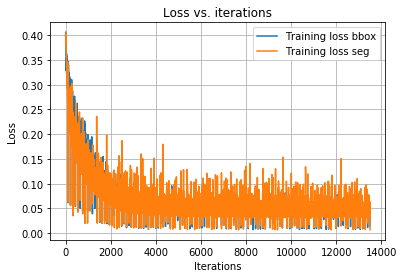

In [11]:
model.save('trained_models/model2_complete.h5')
#Plotting loss 
with open('trained_models/o1_training_loss.pkl', 'wb') as a:
                pickle.dump(history_cb.o1loss, a)
        
with open('trained_models/o2_training_loss.pkl', 'wb') as b:
                pickle.dump(history_cb.o2loss, b)
        
with open('trained_models/o1_validation_loss.pkl', 'wb') as c:
                pickle.dump(history_cb.val_o1loss, c)
        
with open('trained_models/o2_validation_loss.pkl', 'wb') as d:
                pickle.dump(history_cb.val_o2loss, d)
        
# o1_train = pickle.load(open( "trained_models/o1_training_loss.pkl", "rb" ) )
# o2_train = pickle.load(open( "trained_models/o2_training_loss.pkl", "rb" ) )
# o1_val = pickle.load(open( "trained_models/o1_validation_loss.pkl", "rb" ) )
# o2_val = pickle.load(open( "trained_models/o2_validation_loss.pkl", "rb" ) )


plt.plot(history_cb.o1loss)
plt.plot(history_cb.o2loss)
# plt.plot(history_cb.val_o1loss)
# plt.plot(history_cb.val_o2loss)

plt.grid()
plt.title('Loss vs. iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['Training loss bbox','Training loss seg',
            'Testing loss bbox','Testing loss seg'])
plt.show()

In [22]:
def infer(test_image, ground_truth): 
    
    '''
    Input:
            test_image shape: [1,256,256,3]
    
    Output: 
            1. Plots input image with bounding box 
            2. Plots segmented output
    '''
    
    predicted_outputs = model.predict(test_image)
    bounding_box_score = predicted_outputs[0]
    title_for_visual = "predicted bounding boxes"
    
    show_ground_truth = 0
    
    if(show_ground_truth):
        bounding_box_score = ground_truth[:,:,:,0:5]
        title_for_visual = "ground truth bounding boxes"
        
    segmentation_output = predicted_outputs[1]
    
    #Code for bounding box regression inference 
    class_score = bounding_box_score[0,:,:,0]
    
    #Visualizing subcell scores
    plt.imshow(predicted_outputs[0][0,:,:,0])
    plt.title('Predicted scores for subcells')
    plt.show()
        
    #Visualize test image 
    plt.imshow(test_image[0,:,:,:])
    
    
    #Non max supression 
    xs = np.where(class_score>=0.50)[0]
    ys = np.where(class_score>=0.50)[1]
    
    coords = [(xs[i],ys[i]) for i in range(len(xs))]
    
    size = 8
    count = 32
    
    for pair in coords:
        subx = pair[0]
        suby = pair[1]

        sub_sx = subx*size
        sub_ex = sub_sx + 8

        sub_sy = suby*size
        sub_ey = sub_sy + 8

        actual_centerx = (bounding_box_score[0,subx,suby,1]*size) + sub_sx
        actual_centery = (bounding_box_score[0,subx,suby,2]*size) + sub_sy


        xmin = actual_centerx - (bounding_box_score[0,subx,suby,3]*256/2)
        if xmin < 0:
            xmin = 0 
            
        ymin = actual_centery -  (bounding_box_score[0,subx,suby,4]*256/2)
        if ymin < 0:
            ymin = 0
        
        xmax = actual_centerx +  (bounding_box_score[0,subx,suby,3]*256/2)
        if xmax > 255:
            xmax =255
            
        ymax = actual_centery +  (bounding_box_score[0,subx,suby,4]*256/2)
        if ymax > 255:
            ymax = 255
        
        lines_x = []
        lines_y = []
        
        #x is the vertical axis - rows
        #y is the horizontal axis - columns
        #plot command input should be y, then x to follow this chosen convention
        
        for xx in range(int(xmin),int(xmax+1)):
            lines_x.append(xx)
            lines_y.append(int(ymin))
        for xx in range(int(xmin),int(xmax+1)):
            lines_x.append(xx)
            lines_y.append(int(ymax))
        for yy in range(int(ymin),int(ymax+1)):
            lines_y.append(yy)
            lines_x.append(int(xmin))
        for yy in range(int(ymin),int(ymax+1)):
            lines_y.append(yy)
            lines_x.append(int(xmax))
            
        plt.plot(lines_y,lines_x,'go',color = 'magenta', markersize=0.7)
        
    plt.title('Input image with '+title_for_visual)
    plt.show()
    
    
    #Semantic segmentation output 
    plt.imshow(segmentation_output[0,:,:,0])
    plt.title('Segmented image output')
    plt.show()

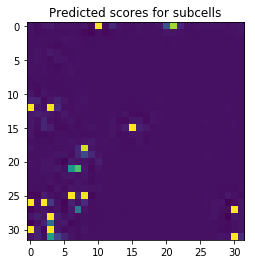

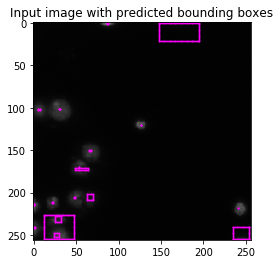

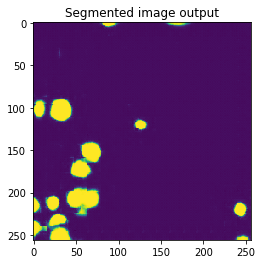

In [23]:
#MAIN 
ch = 45
infer(X_test[ch:ch+1],D_test[ch:ch+1])

In [34]:
def IoU(X_test,Y_test, model): 
    '''
    Input: Set of input images on which to compute IoU 
            and the groud truth. 
    
    Output: 
            IoU = TP/(TP+FN+FP) averaged over two classes (background
                                                        and nuclues)
            
            TP-> True positives
            FN-> False Negatives
            FP-> False positives
    
    '''
    IoU = 0 
    
    for index in range(X_test.shape[0]):
        predicted_outputs = model.predict(X_test[index:index+1])
        segmented_output = predicted_outputs[1]
        
        segmented_output = segmented_output.ravel()
        
        #Thresholding
        segmented_output[np.where(segmented_output>=0.5)[0]] = 1
        segmented_output[np.where(segmented_output<0.5)[0]] = 0
        
        ground_truth = Y_test[index].ravel()
        
        #True positives
        tp_inter = [1 for k in range(len(ground_truth)) 
                    if (segmented_output[k]==1 and ground_truth[k]==1)]
        TP = len(tp_inter)
        
        #False negatives
        fn_inter = [1 for k in range(len(ground_truth)) 
                    if (segmented_output[k]==0 and ground_truth[k]==1)]
        
        FN = len(fn_inter)
        
        #False positives
        fp_inter = [1 for k in range(len(ground_truth)) 
                    if (segmented_output[k]==1 and ground_truth[k]==0)]
        
        FP = len(fp_inter)
        
        IoU+= TP/(TP+FN+FP)
        
        
        #Keeping track 
        if (index+1)%50==0 or (index+1)==X_test.shape[0]:
            print('Tested '+str(index+1)+' Images.')
        
    #Mean IoU 
    MIoU = IoU/X_test.shape[0]
    
    return(MIoU)

In [35]:
print('Computing IOU for testing set...')
IOU = IoU(X_test,Y_test, model)
print('Mean Intersection over Union in testing set = '+str(IOU))
print('\n')

print('Computing IOU for validation set...')
IOU = IoU(X_val,Y_val, model)
print('Mean Intersection over Union in validation set = '+str(IOU))
print('\n')

print('Computing IOU for training set...')
IOU = IoU(X_train,Y_train, model)
print('Mean Intersection over Union in training set = '+str(IOU))
print('\n')

Computing IOU for testing set...
Tested 50 Images.
Tested 67 Images.
Mean Intersection over Union in testing set = 0.7243879893648723


Computing IOU for validation set...
Tested 50 Images.
Tested 67 Images.
Mean Intersection over Union in validation set = 0.713475354197399


Computing IOU for training set...
Tested 50 Images.
Tested 100 Images.
Tested 150 Images.
Tested 200 Images.
Tested 250 Images.
Tested 300 Images.
Tested 350 Images.
Tested 400 Images.
Tested 450 Images.
Tested 500 Images.
Tested 536 Images.
Mean Intersection over Union in training set = 0.7375013421630531


